In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.api import qqplot, add_constant
from statsmodels.stats.stattools import omni_normtest
import statsmodels.formula.api as smf

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# 데이터 구성하기

In [131]:
# 데이터 불러오기
df_raw = pd.read_csv('../Data/3. Big Data 분석/체질검사.csv')
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [132]:
# 결측값 확인
df_raw.isnull().sum()

FAT        0
AGE        0
WEIGHT     0
HEIGHT     0
NECK       0
CHEST      0
ABDOMEN    0
HIP        0
THIGH      0
KNEE       0
ANKLE      0
BICEPS     0
FOREARM    0
WRIST      0
dtype: int64

In [133]:
# 요약 통계량 확인
df_raw.describe()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,44.884921,178.924405,70.148810,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,12.602040,29.389160,3.662856,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,22.000000,118.500000,29.500000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,35.750000,159.000000,68.250000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,43.000000,176.500000,70.000000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,54.000000,197.000000,72.250000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,81.000000,363.150000,77.750000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [135]:
# 파생변수 BMI 지수 계산 (BMI = 체중 / (신장 * 신장))
df_raw['BMI'] = (df_raw['WEIGHT'] * 0.45) / (df_raw['HEIGHT'] * 2.54 / 100) ** 2

In [136]:
# WEIGHT와 HEIGHT로 BMI를 계산했으므로 삭제
df_raw = df_raw.drop(['WEIGHT', 'HEIGHT'], axis=1)

In [137]:
df_raw.head()

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
1,11.8,27,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8,23.082595
2,22.2,69,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8,26.422478
3,10.6,57,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9,23.838617
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165


# 이상치 처리

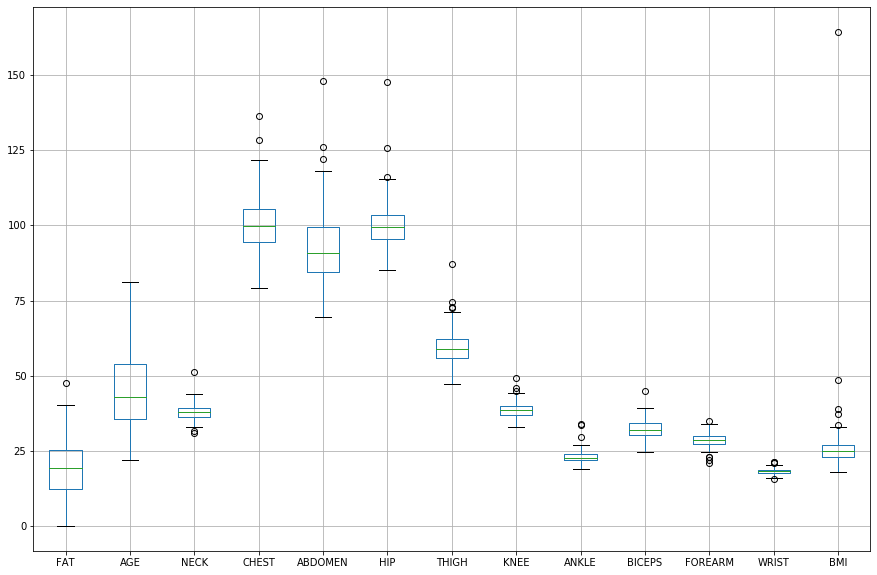

In [105]:
# boxplot으로 이상치 확인
pd.plotting.boxplot(df_raw, figsize=(15,10))

In [106]:
# BMI가 100이 넘어가는 사람은 이상치로 판단하여 삭제
df_raw.sort_values('BMI', ascending=False)

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
78,32.9,44,36.6,106.0,104.3,115.5,70.6,42.5,23.7,33.6,28.7,17.4,164.306562
0,35.2,46,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4,48.523870
82,34.5,45,43.2,128.3,126.2,125.6,72.5,39.6,26.6,36.4,32.7,21.4,38.774160
4,47.5,51,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4,37.293165
117,35.0,65,38.8,119.6,118.0,114.3,61.3,42.1,23.4,34.9,30.1,19.4,33.616780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,15.1,34,36.0,89.2,83.4,89.6,52.4,35.6,20.4,28.3,26.2,16.5,19.646938
230,10.1,27,34.1,88.5,72.8,91.1,53.6,36.8,23.8,27.8,26.3,17.4,19.508426
53,5.3,25,35.2,92.3,76.5,92.1,51.9,35.7,22.0,25.8,25.2,16.9,19.075544
174,7.7,39,31.5,85.1,76.0,88.2,50.0,34.7,21.0,26.1,23.1,16.1,18.893177


In [138]:
# 이상치 제거
df_raw = df_raw.drop(78).reset_index(drop=True)

# 변수 간의 경향성 파악 : 그래프 분석

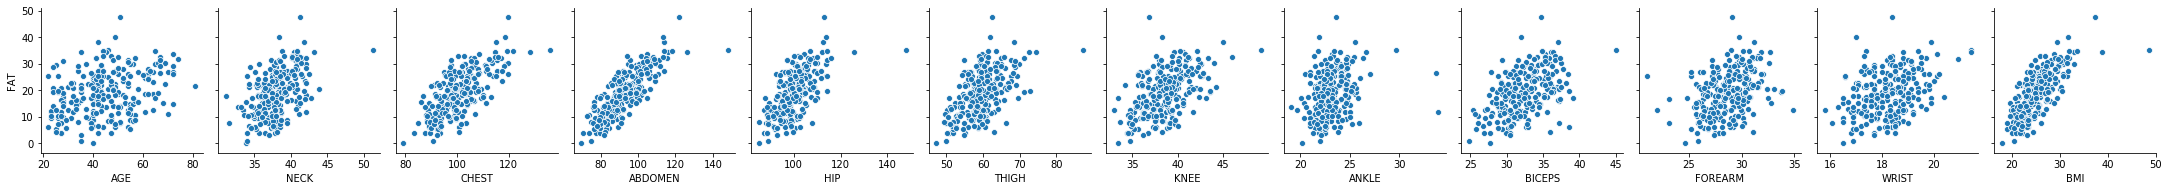

In [129]:
# y변수와 x변수들 간의 산점도 확인
sns.pairplot(df_raw, y_vars = "FAT", x_vars = df_raw.drop('FAT', axis=1).columns)

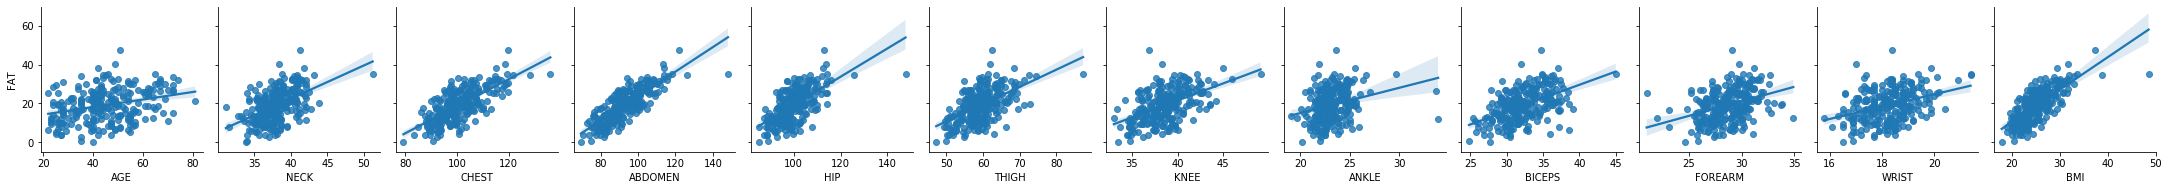

In [39]:
# y변수와 x변수들 간의 산점도 확인2
sns.pairplot(df_raw, y_vars = "FAT", x_vars = df_raw.drop('FAT', axis=1).columns, kind='reg')

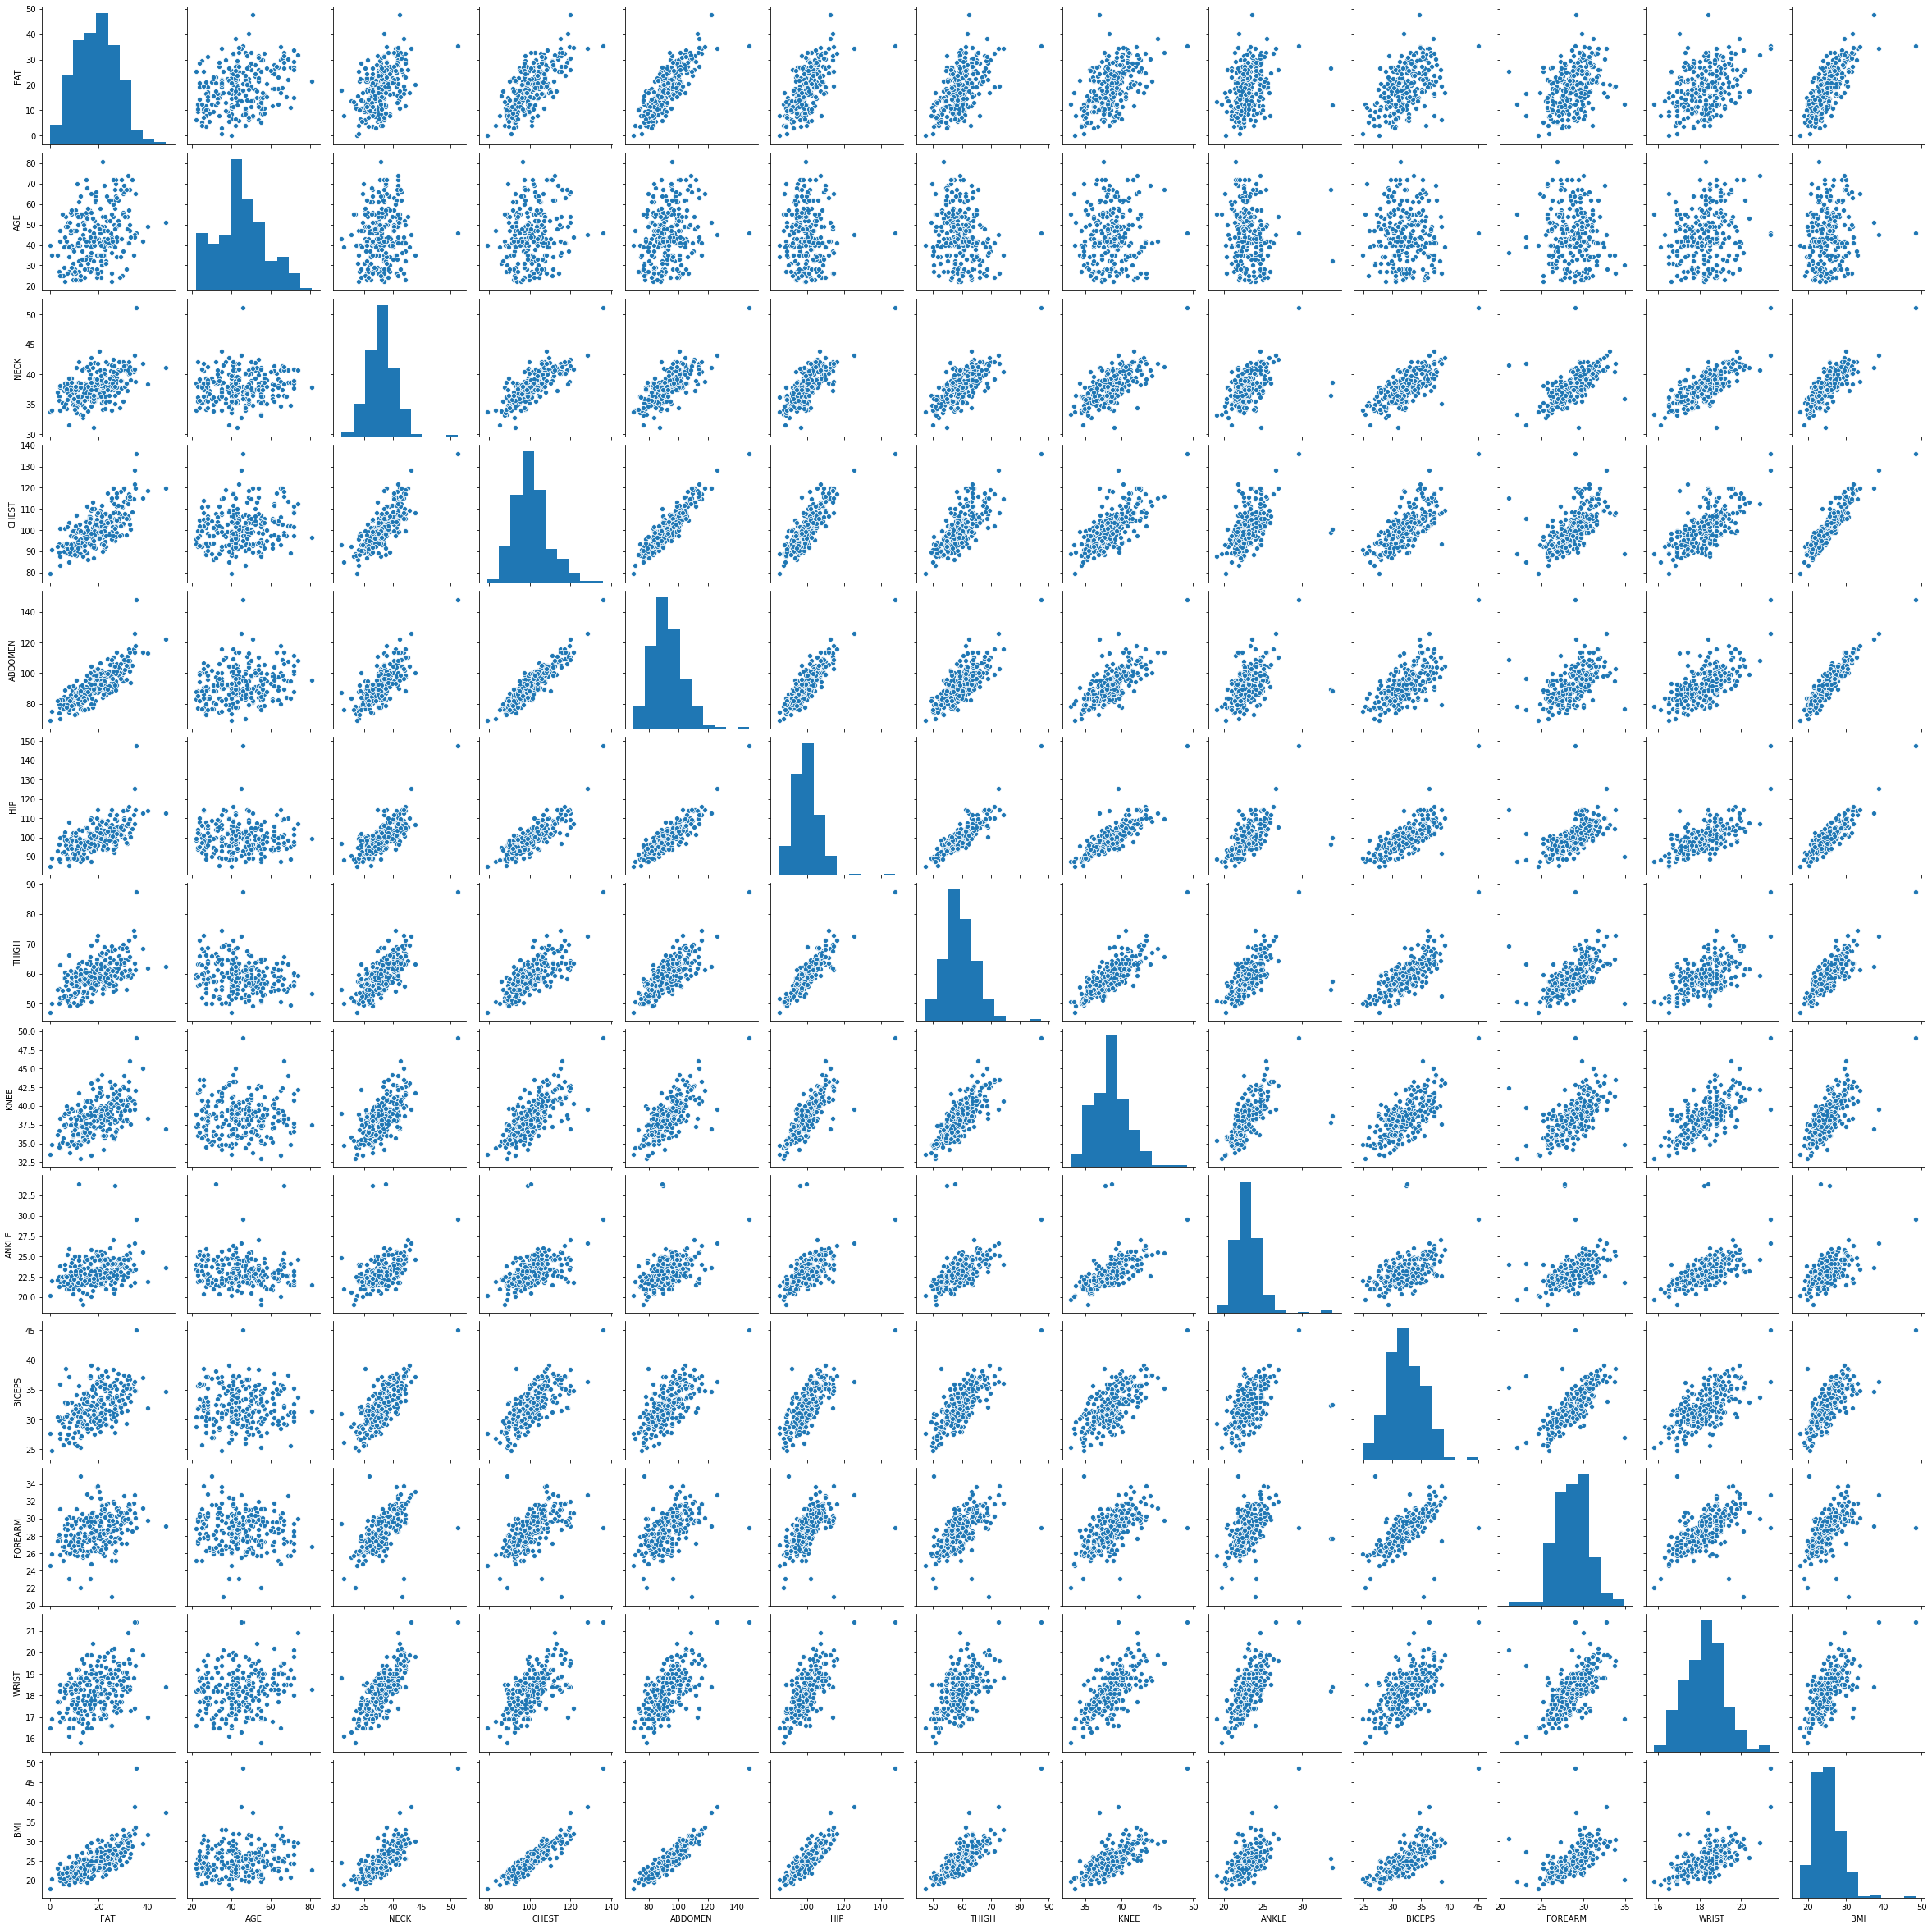

In [40]:
# 각 변수들 간의 산점도 확인
sns.pairplot(df_raw)

In [139]:
# 변수들 간 상관 분석
df_raw.corr().round(3)

,FAT,AGE,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST,BMI
FAT,1.000,0.294,0.497,0.703,0.813,0.620,0.554,0.503,0.265,0.493,0.363,0.355,0.725
AGE,0.294,1.000,0.113,0.177,0.231,-0.050,-0.201,0.018,-0.105,-0.041,-0.085,0.214,0.115
NECK,0.497,0.113,1.000,0.787,0.759,0.748,0.708,0.680,0.479,0.733,0.624,0.744,0.785
CHEST,0.703,0.177,0.787,1.000,0.916,0.833,0.732,0.720,0.483,0.728,0.581,0.664,0.910
ABDOMEN,0.813,0.231,0.759,0.916,1.000,0.875,0.766,0.736,0.453,0.685,0.504,0.626,0.922
HIP,0.620,-0.050,0.748,0.833,0.875,1.000,0.894,0.821,0.561,0.743,0.550,0.645,0.885
THIGH,0.554,-0.201,0.708,0.732,0.766,0.894,1.000,0.797,0.542,0.765,0.572,0.572,0.814
KNEE,0.503,0.018,0.680,0.720,0.736,0.821,0.797,1.000,0.613,0.680,0.559,0.675,0.709
ANKLE,0.265,-0.105,0.479,0.483,0.453,0.561,0.542,0.613,1.000,0.485,0.419,0.568,0.497
BICEPS,0.493,-0.041,0.733,0.728,0.685,0.743,0.765,0.680,0.485,1.000,0.678,0.635,0.747


FAT과 가장 상관관계가 높은 변수 3가지는 ABDOMEN, BMI, CHEST이다.

# 회귀 모델 생성

In [108]:
reg_model=smf.ols(formula="FAT ~ AGE + NECK + CHEST + ABDOMEN + HIP + THIGH + KNEE + ANKLE + BICEPS + FOREARM + WRIST + BMI",data=df_raw)
reg_result=reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     57.26
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           3.53e-63
Time:                        20:01:01   Log-Likelihood:                -717.66
No. Observations:                 251   AIC:                             1461.
Df Residuals:                     238   BIC:                             1507.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.0060      7.711      0.779      0.4

1. 분산분석결과 : p값이 0.05보다 작으므로 회귀모델로서 유의
2. 설명력 : 0.73 -> 모델을 통하여 설명변수 FAT을 73% 설명할 수 있음
3. 회귀계수 검정 : AGE, NECK, ABDOMEN, HIP, FOREARM, WRIST는 p값이 유의수준 0.05보다 작으므로 유의

## 다중공선성 확인

In [109]:
# 변수들의 다중공선성 확인
df_raw_x=df_raw.drop("FAT",axis=1)
df_raw_x_const=add_constant(df_raw_x)

df_vif=pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace=True)
df_vif.round(3)

,variable,VIF
8,ANKLE,1.862
1,AGE,2.067
10,FOREARM,2.195
11,WRIST,3.233
9,BICEPS,3.537
2,NECK,3.973
7,KNEE,4.450
6,THIGH,7.826
3,CHEST,8.999
5,HIP,11.005


VIF가 가장 큰 ABDOMEN을 제거하고 싶으나 FAT과의 상관계수를 생각하여 CHEST를 제거  
CHEST를 제거하는 이유는 ABDOMEN과의 상관성이 가장 높기 때문

In [140]:
# CHEST를 제거하고 다중공선성 확인
df_raw_x=df_raw.drop(["FAT", 'CHEST'],axis=1)
df_raw_x_const=add_constant(df_raw_x)

df_vif=pd.DataFrame()
df_vif["variable"]=df_raw_x_const.columns
df_vif["VIF"]=[variance_inflation_factor(df_raw_x_const.values,i) for i in range(df_raw_x_const.shape[1])]

df_vif.sort_values("VIF",inplace=True)
df_vif.round(3)

,variable,VIF
7,ANKLE,1.862
1,AGE,2.054
9,FOREARM,2.165
10,WRIST,3.224
8,BICEPS,3.484
2,NECK,3.916
6,KNEE,4.389
5,THIGH,7.460
11,BMI,10.079
3,ABDOMEN,10.226


# 후진제거법을 이용한 변수 선택

In [141]:
# 11개의 변수 중 7개 선택

df_raw_y = df_raw['FAT']
model = LinearRegression()
rfe = RFE(estimator=model, n_features_to_select=7).fit(df_raw_x, df_raw_y)
selected_cols = df_raw_x.columns[rfe.support_]
removed_cols = df_raw_x.columns[~rfe.support_]

print(f"Selected Variables: {selected_cols}")
print(f"removed Variables: {removed_cols}")

Selected Variables: Index(['NECK', 'ABDOMEN', 'HIP', 'THIGH', 'FOREARM', 'WRIST', 'BMI'], dtype='object')
removed Variables: Index(['AGE', 'KNEE', 'ANKLE', 'BICEPS'], dtype='object')


In [142]:
# 후진 제거한 변수들로 회귀 모델 생성
rfe_reg_model = smf.ols(formula="FAT ~ NECK + ABDOMEN + HIP + THIGH + FOREARM + WRIST + BMI", data=df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     95.29
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           4.96e-66
Time:                        20:32:25   Log-Likelihood:                -722.33
No. Observations:                 251   AIC:                             1461.
Df Residuals:                     243   BIC:                             1489.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.6335      7.095      1.076      0.2

In [143]:
# THIGH의 p-value가 0.294로 회귀계수가 유의하지 않으므로 제거
rfe_reg_model = smf.ols(formula="FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST + BMI", data=df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.725
Method:                 Least Squares   F-statistic:                     110.9
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           7.80e-67
Time:                        20:33:18   Log-Likelihood:                -722.90
No. Observations:                 251   AIC:                             1460.
Df Residuals:                     244   BIC:                             1484.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8608      7.058      0.972      0.3

In [144]:
# BMI의 p-value가 0.202로 회귀계수가 유의하지 않으므로 제거
rfe_reg_model = smf.ols(formula="FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data=df_raw)
rfe_reg_result = rfe_reg_model.fit()
print(rfe_reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           1.45e-67
Time:                        20:33:46   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5851      6.224      0.415      0.6

1. 분산분석결과 : p값이 0.05보다 작으므로 회귀모델로서 유의
2. 설명력 : 0.724 -> 모델을 통하여 설명변수 FAT을 72.4% 설명할 수 있음
3. 회귀계수 검정 : 모든 변수들의 p값이 유의수준 0.05보다 작으므로 유의

# 잔차 검증

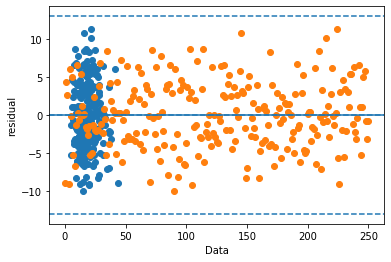

In [145]:
#잔차 산점도
plt.scatter(rfe_reg_result.fittedvalues, rfe_reg_result.resid)
plt.xlabel("fitted value")
plt.ylabel("residual")
plt.axhline(y=0, linestyle="--")

#잔차의 독립성 확인
plt.scatter(df_raw.index, rfe_reg_result.resid, marker="o")
plt.xlabel("Data")
plt.ylabel("residual")
plt.axhline(y=0,linestyle="-")
plt.axhline(y=3*np.std(rfe_reg_result.resid),linestyle="--")
plt.axhline(y=-3*np.std(rfe_reg_result.resid),linestyle="--")

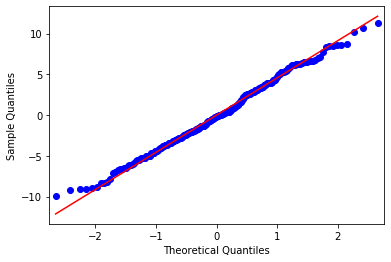

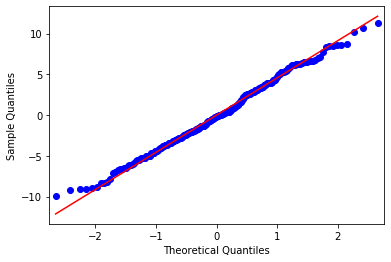

In [146]:
#잔차 정규성검정
qqplot(rfe_reg_result.resid,line="q")

In [147]:
# 정규성 검정 : p-value가 0.05가 넘으므로 정규성이 있다.
omni_normtest(rfe_reg_result.resid,axis=0)

NormaltestResult(statistic=3.70220918965274, pvalue=0.1570635788427655)

# 결론 도출

회귀식 : -0.5720NECK + 0.9771ABDOMEN - 0.3537HIP + 0.4080FOREARM - 1.5647WRIST + 2.5851

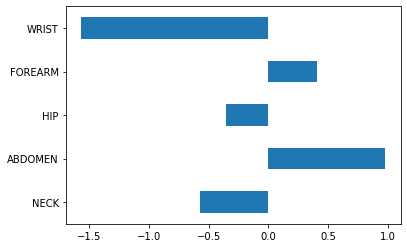

In [151]:
# 비표준화 설명변수 중요도
df_reg_coef=pd.DataFrame({"Coef": rfe_reg_result.params.values[1:]}, index=['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'])
df_reg_coef.plot.barh(y="Coef",legend=False)

In [152]:
# 표준화 적용하여 변수 중요도 재확인
scaler = StandardScaler()
np_scaled = scaler.fit_transform(df_raw_x)
df_scaled = pd.DataFrame(np_scaled, columns=df_raw_x.columns)

df_scaled['FAT'] = df_raw['FAT']
reg_model_scaled = smf.ols(formula="FAT ~ NECK + ABDOMEN + HIP + FOREARM + WRIST", data=df_scaled)
reg_result_scaled = reg_model_scaled.fit()
print(reg_result_scaled.summary())

                            OLS Regression Results                            
Dep. Variable:                    FAT   R-squared:                       0.730
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     132.5
Date:                Mon, 06 Jul 2020   Prob (F-statistic):           1.45e-67
Time:                        20:39:44   Log-Likelihood:                -723.73
No. Observations:                 251   AIC:                             1459.
Df Residuals:                     245   BIC:                             1481.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.0960      0.276     69.106      0.0

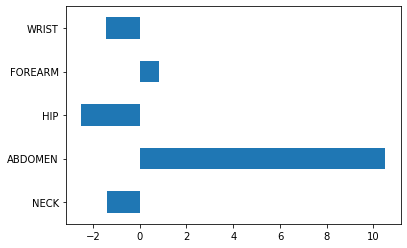

In [153]:
# 표준화 설명변수 중요도
df_reg_coef=pd.DataFrame({"Coef": reg_result_scaled.params.values[1:]}, index=['NECK', 'ABDOMEN', 'HIP', 'FOREARM', 'WRIST'])
df_reg_coef.plot.barh(y="Coef",legend=False)

회귀계수의 방향은 동일하나 중요도 크기가 변함  
ABDOMEN이 가장 중요하고 WRIST의 중요도는 줄어든 반면 HIP의 중요도는 증가함  
단, 모델의 통계량은 변화 없음